In [39]:
from sklearn.base import BaseEstimator, RegressorMixin
from scipy.optimize import minimize
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV, PredefinedSplit
from sklearn.model_selection import ParameterGrid
from sklearn.metrics import mean_squared_error, make_scorer
import pandas as pd
import random

from setup_problem import load_problem

In [2]:
def lasso_objective_func(X, y, w, lambda_reg):
    loss = np.sum((np.dot(X,w)-y)**2)
    l1 = lambda_reg*np.linalg.norm(w, ord=1)
    
    return loss + l1

In [4]:
X = np.array([[1,2,3],[4,5,6]])
y = np.array([7,8])
w = np.array([1,2,3])
lasso_objective_func(X, y, w, 1)

631.0

In [11]:
a = np.array([2,3,4])
np.dot(a.T,w)

20

In [14]:
np.linalg.norm(np.array([-1,-2,3]),ord=1)

6.0

In [33]:
[{'l1reg':np.unique(np.concatenate((10.**np.arange(-6,1,1),
                                           np.arange(1,3,.3)
                                             ))) }]

[{'l1reg': array([1.0e-06, 1.0e-05, 1.0e-04, 1.0e-03, 1.0e-02, 1.0e-01, 1.0e+00,
         1.3e+00, 1.6e+00, 1.9e+00, 2.2e+00, 2.5e+00, 2.8e+00])}]

In [76]:
np.linspace(0, 1, 11, endpoint=False)

array([0.        , 0.09090909, 0.18181818, 0.27272727, 0.36363636,
       0.45454545, 0.54545455, 0.63636364, 0.72727273, 0.81818182,
       0.90909091])

In [12]:
def lasso_shooting_algo(X, y, lambda_reg):
    w = np.dot(X.T,X)+lambda_reg*np.identity(X.shape[1])
    w = np.linalg.inv(w)
    w = np.dot(w,X.T)
    w = np.dot(w,y)
    
    def soft(a, delta):
        temp = abs(a) - delta
        if temp <= 0:
            return 0
        else:
            return np.sign(a)*temp
    
    while lasso_objective_func(X, y, w, lambda_reg) > 1e-8:
        for j in range(X.shape[1]):
            a_j = 2*np.sum((X[:,j]**2))
            
            c_j = y - np.dot(X,w) + w[j]*X[:,j]
            c_j = 2*np.dot(X[:,j],c_j)
            
            w[j] = soft(c_j/a_j, lambda_reg/a_j)
    
    return w
            
    

In [58]:
class LassoRegression(BaseEstimator, RegressorMixin): ## BaseEstimator를 상속받으면 GridSearchCV를 쓸 수 있다.
    """ ridge regression"""

    def __init__(self, l1reg=1):
        if l1reg < 0:
            raise ValueError('Regularization penalty should be at least 0.')
        self.l1reg = l1reg
        self.max_step = 1000

    
    def fit(self, X, y=None, set_w_to_zero = False):
        
        def lasso_objective_func(X, y, w, lambda_reg):
            loss = np.sum((np.dot(X,w)-y)**2)
            l1 = lambda_reg*np.linalg.norm(w, ord=1)
            return loss + l1

        def soft(a, delta):
            temp = abs(a) - delta
            if temp <= 0:
                return 0
            else:
                return np.sign(a)*temp
        
        if set_w_to_zero:
            w = np.zeros(X.shape[1])
        else:
            w = np.dot(X.T,X)+self.l1reg*np.identity(X.shape[1])
            w = np.linalg.inv(w)
            w = np.dot(w,X.T)
            w = np.dot(w,y)
        
        step = 0
        while lasso_objective_func(X, y, w, self.l1reg) > 1e-8 and step < self.max_step:
            step += 1
            for j in range(X.shape[1]):
                a_j = 2*np.sum((X[:,j]**2))

                c_j = y - np.dot(X,w) + w[j]*X[:,j]
                c_j = 2*np.dot(X[:,j],c_j)
                
                if a_j == 0:
                    w[j] = 0
                else:
                    w[j] = soft(c_j/a_j, self.l1reg/a_j)
        
        self.w_ = w ## _는 convention 같은거임.내부적으로 사용되는 변수라는 뜻이며 다른 기본 키워드들과의 충돌을 피하기 위함.
        return self

    def predict(self, X, y=None):
        try:
            getattr(self, "w_") ## getattr(object, 'x') 은 object.x와 완전히 동일하다.
        except AttributeError:
            raise RuntimeError("You must train classifer before predicting data!")
        return np.dot(X, self.w_)

    def score(self, X, y):
        # Average square error
        try:
            getattr(self, "w_")
        except AttributeError:
            raise RuntimeError("You must train classifer before predicting data!")
        residuals = self.predict(X) - y
        return np.dot(residuals, residuals)/len(y)

In [50]:
class LassoRegression_random_coodinate(BaseEstimator, RegressorMixin):
    """ ridge regression"""

    def __init__(self, l1reg=1):
        if l1reg < 0:
            raise ValueError('Regularization penalty should be at least 0.')
        self.l1reg = l1reg
        self.max_step = 1000

    
    def fit(self, X, y=None):
        
        def lasso_objective_func(X, y, w, lambda_reg):
            loss = np.sum((np.dot(X,w)-y)**2)
            l1 = lambda_reg*np.linalg.norm(w, ord=1)
            return loss + l1

        def soft(a, delta):
            temp = abs(a) - delta
            if temp <= 0:
                return 0
            else:
                return np.sign(a)*temp
            
        w = np.dot(X.T,X)+self.l1reg*np.identity(X.shape[1])
        w = np.linalg.inv(w)
        w = np.dot(w,X.T)
        w = np.dot(w,y)
        
        step = 0
        while lasso_objective_func(X, y, w, self.l1reg) > 1e-8 and step < self.max_step:
            step += 1
            index = list(range(X.shape[1]))
            random.shuffle(index)
            for j in index:
                a_j = 2*np.sum((X[:,j]**2))

                c_j = y - np.dot(X,w) + w[j]*X[:,j]
                c_j = 2*np.dot(X[:,j],c_j)
                
                if a_j == 0:
                    w[j] = 0
                else:
                    w[j] = soft(c_j/a_j, self.l1reg/a_j)
        
        self.w_ = w ## _는 convention 같은거임.내부적으로 사용되는 변수라는 뜻이며 다른 기본 키워드들과의 충돌을 피하기 위함.
        return self

    def predict(self, X, y=None):
        try:
            getattr(self, "w_") ## getattr(object, 'x') 은 object.x와 완전히 동일하다.
        except AttributeError:
            raise RuntimeError("You must train classifer before predicting data!")
        return np.dot(X, self.w_)

    def score(self, X, y):
        # Average square error
        try:
            getattr(self, "w_")
        except AttributeError:
            raise RuntimeError("You must train classifer before predicting data!")
        residuals = self.predict(X) - y
        return np.dot(residuals, residuals)/len(y)

In [64]:
def do_grid_search_ridge(X_train, y_train, X_val, y_val):
    # Now let's use sklearn to help us do hyperparameter tuning
    # GridSearchCv.fit by default splits the data into training and
    # validation itself; we want to use our own splits, so we need to stack our
    # training and validation sets together, and supply an index
    # (validation_fold) to specify which entries are train and which are
    # validation.
    X_train_val = np.vstack((X_train, X_val))
    y_train_val = np.concatenate((y_train, y_val))
    val_fold = [-1]*len(X_train) + [0]*len(X_val) #0 corresponds to validation

    # Now we set up and do the grid search over l2reg. The np.concatenate
    # command illustrates my search for the best hyperparameter. In each line,
    # I'm zooming in to a particular hyperparameter range that showed promise
    # in the previous grid. This approach works reasonably well when
    # performance is convex as a function of the hyperparameter, which it seems
    # to be here.

#     param_grid = [{'l1reg':np.unique(np.arange(0.01,0.1,0.01))}] ## LassoRegression()의 인수로 l1reg=0.01부터 차례로 들어감.
#     param_grid = [{'l1reg':np.unique(np.arange(0.1,1,0.1))}]
#     param_grid = [{'l1reg':np.unique(np.arange(1,10,1))}]
#     param_grid = [{'l1reg':np.unique(np.arange(1,2,0.1))}]
    param_grid = [{'l1reg':np.unique(np.arange(1,1.4,0.1))}]

    lasso_regression_estimator = LassoRegression()
    grid = GridSearchCV(lasso_regression_estimator,
                        param_grid,
                        return_train_score=True,
                        cv = PredefinedSplit(test_fold=val_fold),
                        refit = True,
                        scoring = make_scorer(mean_squared_error,
                                              greater_is_better = False))
    grid.fit(X_train_val, y_train_val)

    df = pd.DataFrame(grid.cv_results_)
    # Flip sign of score back, because GridSearchCV likes to maximize, ### 음수로 바꿔서 최대화 하는 것은 원래것을 최소화 하는 것과 같다.
    # so it flips the sign of the score if "greater_is_better=FALSE"
    df['mean_test_score'] = -df['mean_test_score']
    df['mean_train_score'] = -df['mean_train_score']
    cols_to_keep = ["param_l1reg", "mean_test_score","mean_train_score"]
    df_toshow = df[cols_to_keep].fillna('-')
    df_toshow = df_toshow.sort_values(by=["param_l1reg"])
    return grid, df_toshow

In [62]:
def compare_parameter_vectors(pred_fns):
    # Assumes pred_fns is a list of dicts, and each dict has a "name" key and a
    # "coefs" key
    fig, axs = plt.subplots(len(pred_fns),1, sharex=True, figsize=(6,12))
    num_ftrs = len(pred_fns[0]["coefs"])
    for i in range(len(pred_fns)):
        title = pred_fns[i]["name"]
        coef_vals = pred_fns[i]["coefs"]
        axs[i].bar(range(num_ftrs), coef_vals)
        axs[i].set_xlabel('Feature Index')
        axs[i].set_ylabel('Parameter Value')
        axs[i].set_title(title)

    fig.subplots_adjust(hspace=0.3)
    return fig

In [63]:
def plot_prediction_functions(x, pred_fns, x_train, y_train, legend_loc="best"):
    # Assumes pred_fns is a list of dicts, and each dict has a "name" key and a
    # "preds" key. The value corresponding to the "preds" key is an array of
    # predictions corresponding to the input vector x. x_train and y_train are
    # the input and output values for the training data
    fig, ax = plt.subplots(figsize = (20,12))
    ax.set_xlabel('Input Space: [0,1)')
    ax.set_ylabel('Action/Outcome Space')
    ax.set_title("Prediction Functions")
    plt.scatter(x_train, y_train, label='Training data')
    for i in range(len(pred_fns)):
        ax.plot(x, pred_fns[i]["preds"], label=pred_fns[i]["name"])
    legend = ax.legend(loc=legend_loc, shadow=True)
    return fig

In [73]:
def main():
    lasso_data_fname = "lasso_data.pickle"
    x_train, y_train, x_val, y_val, target_fn, coefs_true, featurize = load_problem(lasso_data_fname)

    # Generate features
    X_train = featurize(x_train)
    X_val = featurize(x_val)



    # Do hyperparameter tuning with our ridge regression
    grid, results = do_grid_search_ridge(X_train, y_train, X_val, y_val)
    print(results)

    # Plot validation performance vs regularization parameter
    fig, ax = plt.subplots()
#    ax.loglog(results["param_l2reg"], results["mean_test_score"])
    ax.semilogx(results["param_l1reg"], results["mean_test_score"])
    ax.grid()
    ax.set_title("Validation Performance vs L2 Regularization")
    ax.set_xlabel("L1-Penalty Regularization Parameter")
    ax.set_ylabel("Mean Squared Error")
    fig.show()

    # Let's plot prediction functions and compare coefficients for several fits
    # and the target function.
    
#     pred_fns = []
#     x = np.sort(np.concatenate([np.arange(0,1,.001), x_train]))
#     name = "Target Parameter Values (i.e. Bayes Optimal)"
#     pred_fns.append({"name":name, "coefs":coefs_true, "preds": target_fn(x) })

#     l1regs = [0, grid.best_params_['l1reg'], 1]
#     X = featurize(x)
#     for l1reg in l1regs:
#         lasso_regression_estimator = LassoRegression(l1reg=l1reg)
#         lasso_regression_estimator.fit(X_train, y_train)
#         name = "lasso with L1Reg="+str(l1reg)
#         pred_fns.append({"name":name,
#                          "coefs":lasso_regression_estimator.w_,
#                          "preds": lasso_regression_estimator.predict(X) })

#     f = plot_prediction_functions(x, pred_fns, x_train, y_train, legend_loc="best")
#     f.show()

#     f = compare_parameter_vectors(pred_fns)
#     f.show()


In [72]:
def main2():
    lasso_data_fname = "lasso_data.pickle"
    x_train, y_train, x_val, y_val, target_fn, coefs_true, featurize = load_problem(lasso_data_fname)

    # Generate features
    X_train = featurize(x_train)
    X_val = featurize(x_val)





    # Let's plot prediction functions and compare coefficients for several fits
    # and the target function.
    
    pred_fns = []
    x = np.sort(np.concatenate([np.arange(0,1,.001), x_train]))
    name = "Target Parameter Values (i.e. Bayes Optimal)"
    pred_fns.append({"name":name, "coefs":coefs_true, "preds": target_fn(x) })

    l1regs = [1.2]
    X = featurize(x)
    for l1reg in l1regs:
        lasso_regression_estimator = LassoRegression(l1reg=l1reg)
        lasso_regression_estimator.fit(X_train, y_train)
        name = "lasso with L1Reg="+str(l1reg)
        pred_fns.append({"name":name,
                         "coefs":lasso_regression_estimator.w_,
                         "preds": lasso_regression_estimator.predict(X) })

    f = plot_prediction_functions(x, pred_fns, x_train, y_train, legend_loc="best")
    f.show()

    f = compare_parameter_vectors(pred_fns)
    f.show()

# lambda = 1.2~1.3에서 최소

   param_l1reg  mean_test_score  mean_train_score
0         0.01         0.171411          0.006805
1         0.02         0.170180          0.006964
2         0.03         0.169033          0.007228
3         0.04         0.167876          0.007572
4         0.05         0.166753          0.007987
5         0.06         0.165677          0.008479
6         0.07         0.164753          0.009037
7         0.08         0.163881          0.009679
8         0.09         0.162982          0.010392


<ipython-input-17-f3171d28f6ee>:23: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


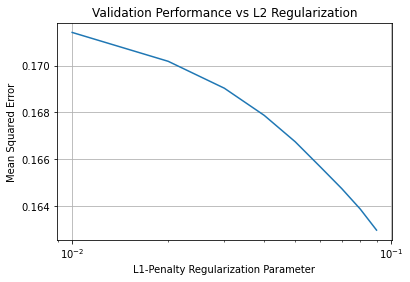

In [25]:
if __name__ == '__main__':
  main()

   param_l1reg  mean_test_score  mean_train_score
0          1.0         0.126438          0.091950
1          1.1         0.126065          0.094844
2          1.2         0.125951          0.095711
3          1.3         0.125951          0.096654
4          1.4         0.126064          0.097672
5          1.5         0.126192          0.098766
6          1.6         0.126450          0.099935
7          1.7         0.126767          0.101180
8          1.8         0.127151          0.102499
9          1.9         0.127530          0.103895


<ipython-input-17-f3171d28f6ee>:23: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


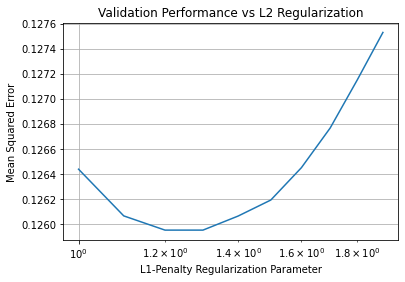

In [37]:
if __name__ == '__main__':
  main()

# random coordinate descent와 비교
 - 점수가 더 잘나오긴 하지만 random coordinate descent가 더 좋다는 뜻은 아닌 것 같다.
 - 생각해보면 순서대로 하나 random으로 하나 다를게 없음.
 - 원래 X를 쓰나 X의 열을 셔플해준 새로운 X'을 쓰나 결과가 달라지진 않기 때문.

In [52]:
lasso_random_coodinate = LassoRegression_random_coodinate(l1reg = 1.2)

In [53]:
lasso_data_fname = "lasso_data.pickle"
x_train, y_train, x_val, y_val, target_fn, coefs_true, featurize = load_problem(lasso_data_fname)
X_train = featurize(x_train)
X_val = featurize(x_val)

lasso_random_coodinate.fit(X_train,y_train)

LassoRegression_random_coodinate(l1reg=1.2)

In [57]:
lasso_random_coodinate.score(X_val, y_val)

0.12470221703857617

# w의 초기값을 0으로 할 경우
 - 점수가 훨씬 안좋아짐. 왜 일까?
 - 일단 lasso에서 coodinate descent는 closed form solution을 가진다.
 - 즉, w의 초기값에 상관없이 결국엔 solution에 수렴한다.
 - 다만 내가 위에서 구현한 함수는 max_step을 1000으로 제한해놓았다.
 - w를 0으로 초기화하면 solution과 더 멀리 있게 될 여지가 크므로 max_step이 1000으로 제한되어 있으면 최적점 근처에 가지 못한채로 끝날 수 있다.
 - w를 ridge regression의 solution으로 초기화하면 lasso에서의 최적점에 보다 가까운 점에서 시작하므로 이런 결과가 나온 것.

In [59]:
lasso = LassoRegression(l1reg = 1.2)

In [60]:
lasso.fit(X_train, y_train, set_w_to_zero=True)

LassoRegression(l1reg=1.2)

In [61]:
lasso.score(X_val, y_val)

0.16747102920538232

#  target function과의 비교
 - ridge보다 확실히 더 비슷하다.
 - ridge는 여러 feature에 가중치를 골고루 주려 하지만 lasso는 중요한 feature에만 가중치를 몰아주기 때문.
 - validation set과의 스코어를 비교해 봐도 ridge는 1.4점대였음.

<ipython-input-72-450793f23d69>:32: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  f.show()
<ipython-input-72-450793f23d69>:35: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  f.show()


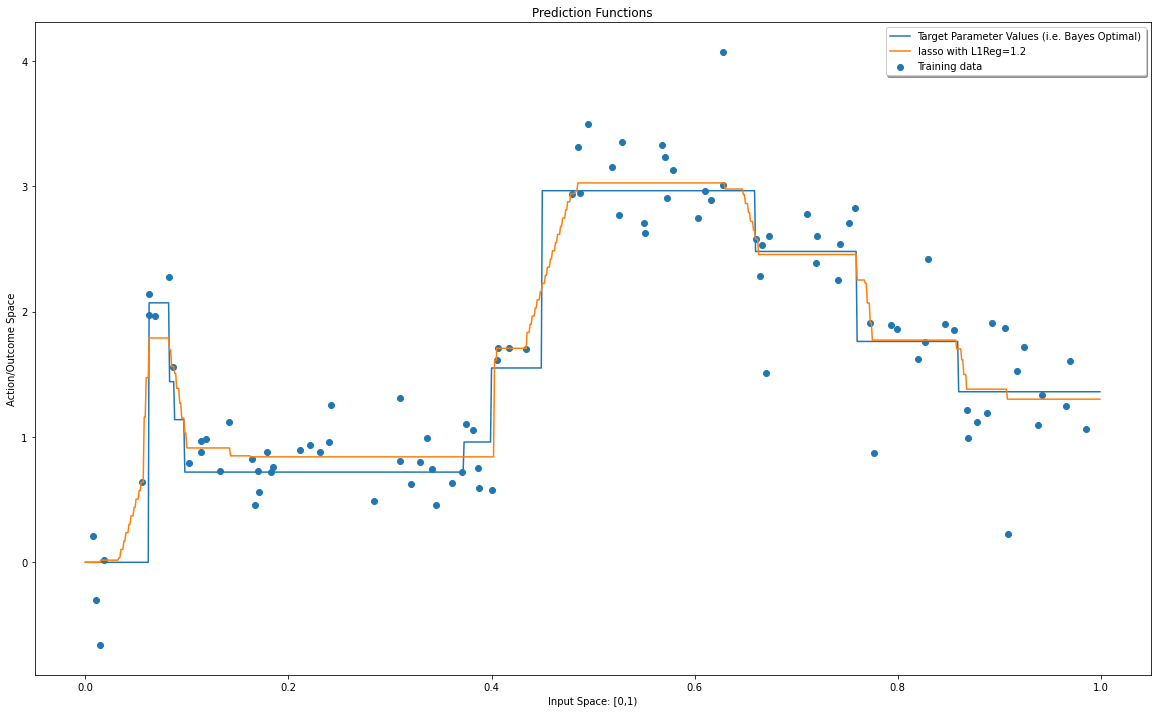

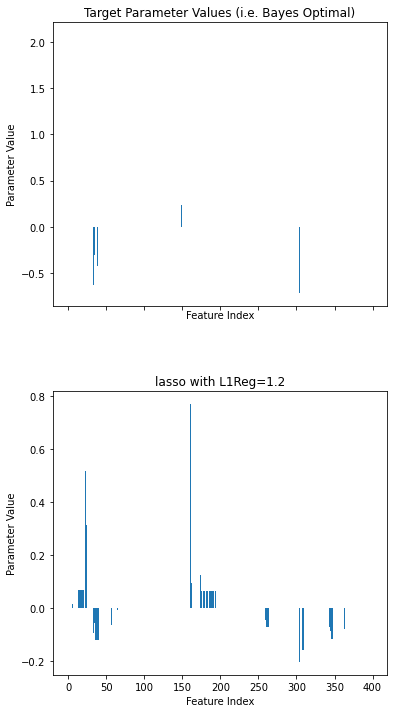

In [74]:
if __name__ == '__main__':
  main2()